#### DR Preprocessing Comparison
Need to figure out the best way to reduce the dimensionality of the scRNA-seq data prior to calculating EMDs for subpopulation comparison.

In [2]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline

Using TensorFlow backend.


In [58]:
# reload functions when editing file
import sys
del sys.modules['utilityfunctions']
from utilityfunctions import *

Read in data files and associate barcodes with RNA counts

In [3]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 31.7 s, sys: 4.85 s, total: 36.6 s
Wall time: 37.5 s


In [4]:
top20 = list(range(1,21))

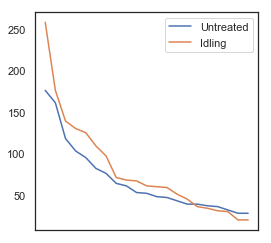

In [5]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top20)).plot(label='Idling', legend=True)
plt.show()

In [6]:
# get list of codes to use throughout the rest of analysis
# top 20 codes in Untreated control set
selected_codes = U.top_barcodes(top20)

Perform PCA on each dataset to prime DRs

In [7]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(), barcodes=U.barcodes, n_components=100)

CPU times: user 13.6 s, sys: 1.81 s, total: 15.4 s
Wall time: 9.95 s


In [8]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(), barcodes=I.barcodes, n_components=100)

CPU times: user 17.2 s, sys: 2.42 s, total: 19.6 s
Wall time: 13.4 s


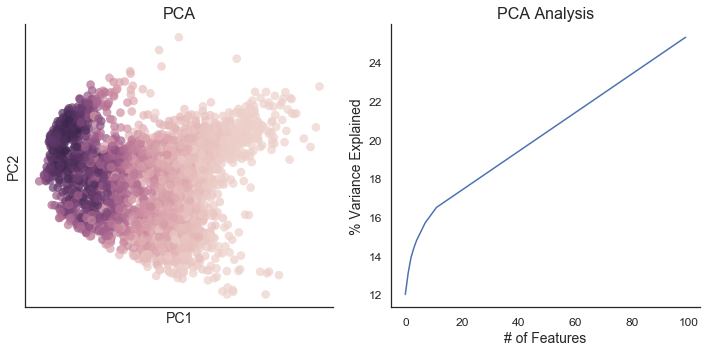

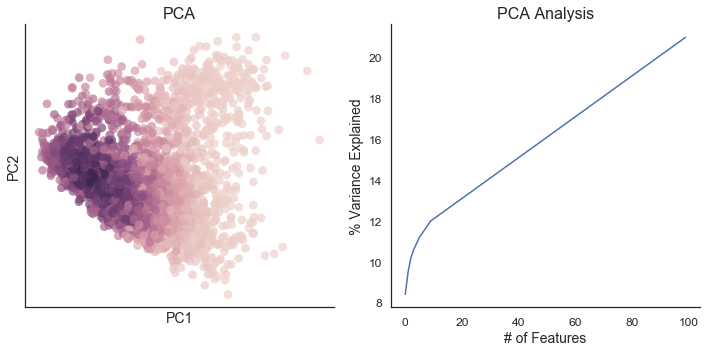

In [18]:
# visualize both PCAs
U_PCA.plot()
I_PCA.plot()

---
### t-SNE
Primed with 100-component PCA. FIt-SNE implementation.

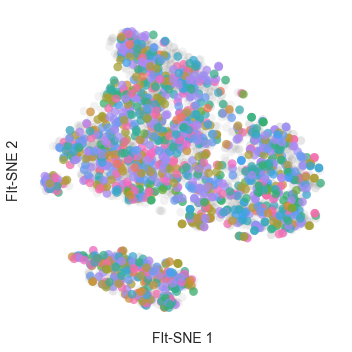

CPU times: user 964 ms, sys: 112 ms, total: 1.08 s
Wall time: 29.2 s


In [9]:
%%time 
U_FItSNE = fcc_FItSNE(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_FItSNE.plot_barcodes(ranks=selected_codes)

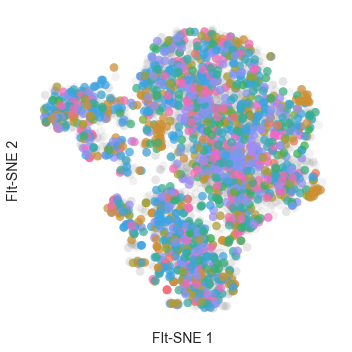

CPU times: user 1.24 s, sys: 95 ms, total: 1.33 s
Wall time: 24.1 s


In [10]:
%%time 
I_FItSNE = fcc_FItSNE(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_FItSNE.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

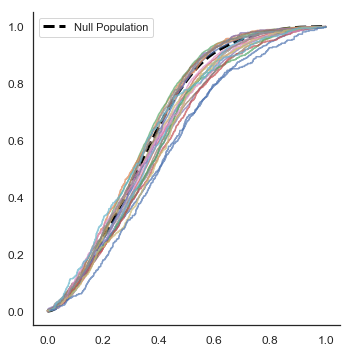

CPU times: user 31.9 s, sys: 997 ms, total: 32.9 s
Wall time: 32.7 s


In [11]:
%%time
U_out = compare_barcode_distances(obj=U_FItSNE, barcodes=selected_codes)

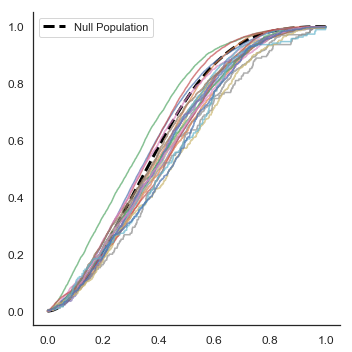

CPU times: user 49.5 s, sys: 1.8 s, total: 51.3 s
Wall time: 51.4 s


In [12]:
%%time
I_out = compare_barcode_distances(obj=I_FItSNE, barcodes=selected_codes)

In [13]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_FItSNE, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 3min 57s, sys: 5.35 s, total: 4min 3s
Wall time: 4min 3s


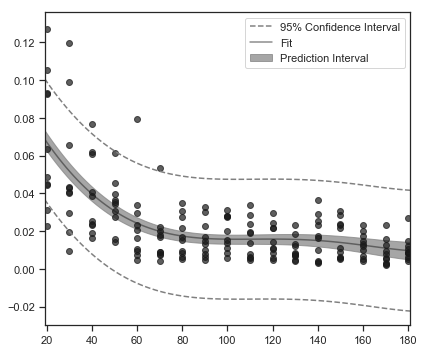

In [26]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'], deg=5)

Do the same as above for __Idling__ dataset

In [15]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_FItSNE, pop_sizes=np.arange(20, 261, 10), iter=10)

CPU times: user 9min 4s, sys: 12.3 s, total: 9min 17s
Wall time: 11min 18s


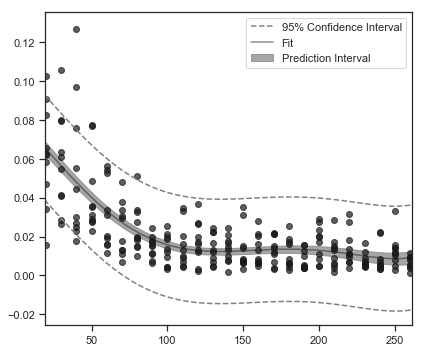

In [25]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'], deg=5)

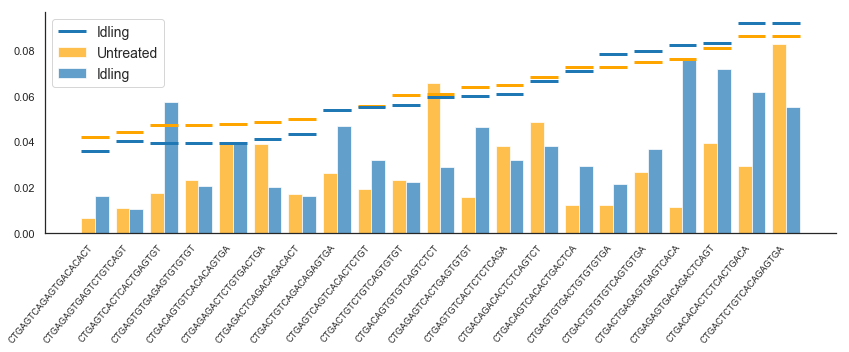

In [27]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], label='Idling',
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### UMAP
Primed with 100-component PCA. 

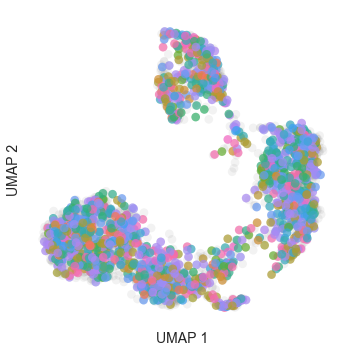

CPU times: user 12.4 s, sys: 549 ms, total: 13 s
Wall time: 12.8 s


In [28]:
%%time 
U_UMAP = fcc_UMAP(U_PCA.results, perplexity=30, barcodes=U_PCA.barcodes) 
U_UMAP.plot_barcodes(ranks=selected_codes)

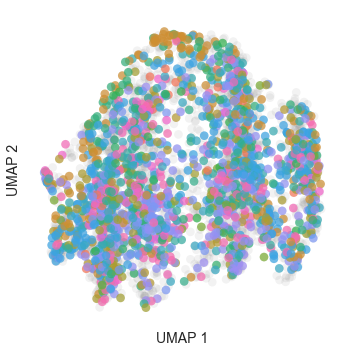

CPU times: user 9.83 s, sys: 483 ms, total: 10.3 s
Wall time: 9.76 s


In [29]:
%%time 
I_UMAP = fcc_UMAP(I_PCA.results, perplexity=30, barcodes=I_PCA.barcodes) 
I_UMAP.plot_barcodes(ranks=selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

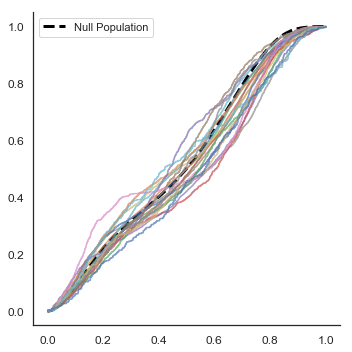

CPU times: user 32.6 s, sys: 1.12 s, total: 33.7 s
Wall time: 33.6 s


In [30]:
%%time
U_out = compare_barcode_distances(obj=U_UMAP, barcodes=selected_codes)

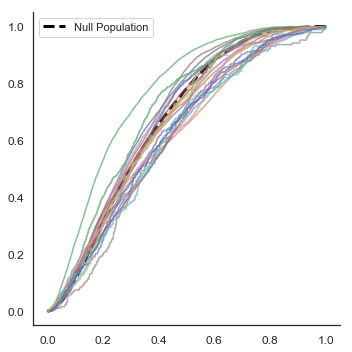

CPU times: user 49.5 s, sys: 1.72 s, total: 51.2 s
Wall time: 51 s


In [31]:
%%time
I_out = compare_barcode_distances(obj=I_UMAP, barcodes=selected_codes)

In [32]:
%%time
# range of top 20 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
U_curve = cell_bias_curve(obj=U_UMAP, pop_sizes=np.arange(20, 181, 10), iter=10)

CPU times: user 4min 3s, sys: 7.44 s, total: 4min 11s
Wall time: 4min 17s


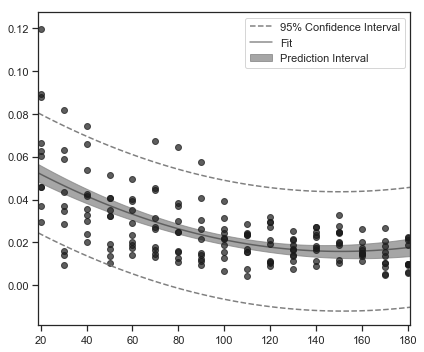

In [33]:
# plot 2nd degree polynomial regression
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'], deg=2)

Do the same as above for __Idling__ dataset

In [34]:
%%time
# range of top 20 barcodes in idling dataset is 20 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
I_curve = cell_bias_curve(obj=I_UMAP, pop_sizes=np.arange(20, 261, 10), iter=5)

CPU times: user 4min 37s, sys: 8.76 s, total: 4min 45s
Wall time: 4min 47s


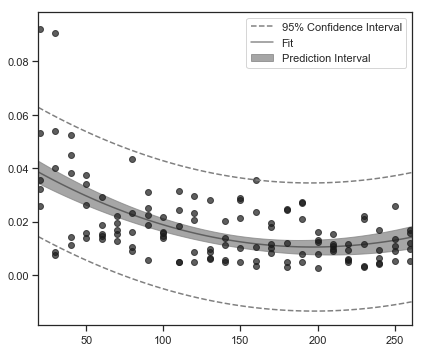

In [35]:
# plot 2nd degree polynomial regression
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'], deg=2)

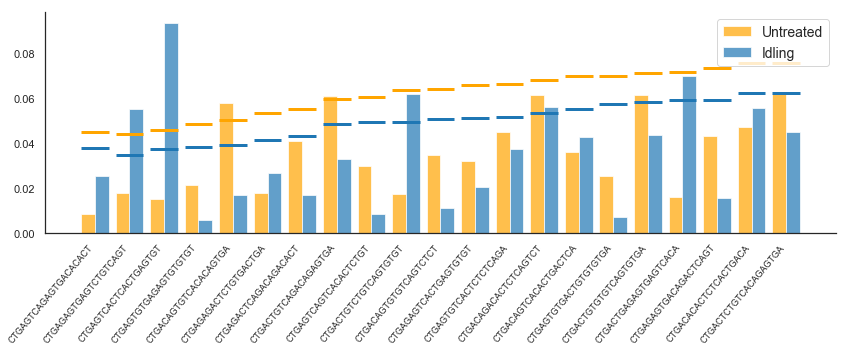

In [36]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()